In [1]:
import os
os.environ.pop("OPENBLAS_NUM_THREADS", None)   #  None = ignore if not present

import copy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.metrics import mean_squared_error
import shap
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, RecursiveFeatureElimination
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import OutlierTrimmer
from catboost import CatBoostRegressor, Pool

SEED = 23

pd.set_option('display.max_columns', None)

In [2]:
#pip install --force-reinstall --upgrade git+https://github.com/SerjWeesp/AmarinML.git

In [3]:
from amarinml import *

In [4]:
df = pd.read_csv('D:/OneDrive/datasets/sp500_diff.csv', low_memory=False)
print(df.shape)

(27723, 402)


In [5]:
df.drop(columns=['Unnamed: 0'], axis=1, inplace = True)

In [6]:
df = df.sort_values(by=['Ticker','Date'])

In [7]:
target = 'Future_Price_pct_diff_1'
df[target]=df.groupby('Ticker')['ClosePrice_pct_diff_1'].shift(1)

In [8]:
features = df.drop(columns=[target], axis=1).columns.tolist()
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_features =  df.select_dtypes(include=['int64', 'float64']).columns.tolist()                                                                                 

In [9]:
len(num_features), len(cat_features), len(features)

(398, 4, 401)

In [10]:
df.dropna(inplace = True)

In [11]:
df = df.replace([np.inf, -np.inf], 0)

In [12]:
df = df.sort_values(by=['Date','Ticker'])

In [13]:
df.loc[df['Date'] > '2024-01-01'].value_counts().head(10)

Ticker  Date        Basic EPS  Basic Shares Outstanding  Cash Flow From Financial Activities  Cash Flow From Investing Activities  Cash Flow From Operating Activities  Cash On Hand  Change In Accounts Payable  Change In Accounts Receivable  Change In Assets/Liabilities  Change In Inventories  ClosePrice  Common Stock Dividends Paid  Common Stock Net  Comprehensive Income  Cost Of Goods Sold  CountDividends  Debt Issuance/Retirement Net - Total  EBIT      EBITDA    EPS - Earnings Per Share  Financial Activities - Other  Goodwill And Intangible Assets  Gross Profit  Income After Taxes  Income From Continuous Operations  Income From Discontinued Operations  Income Taxes  Inventory  Investing Activities - Other  Long Term Debt  Long-Term Investments  MACD       MACD_Hist  MACD_Signal  MaxPrice    MaxVolume   MeanDividends  MeanPrice   MeanVolume    MedianPrice  MedianVolume  MinPrice    MinVolume  Net Acquisitions/Divestitures  Net Cash Flow  Net Change In Intangible Assets  Net Change In 

In [14]:
split_date = '2024-01-01'
train_df, test_df = df.loc[df['Date'] < split_date], df.loc[df['Date'] >= split_date]

In [15]:
#train_df_cut = train_df.copy()
#trimmer = OutlierHandler(WinsorizerHandler(lower_quantile=0.01, upper_quantile=0.99))
#train_df_cut[num_features] = trimmer.fit_transform(train_df[num_features])

In [16]:
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

In [17]:
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=8,
    random_seed=SEED,
    verbose=50,
    thread_count=-1,  # Use all available threads
    task_type="CPU"   # Ensure CPU is used
)

In [18]:
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test))

0:	learn: 0.1417577	test: 0.1441596	best: 0.1441596 (0)	total: 280ms	remaining: 4m 39s
50:	learn: 0.0654134	test: 0.0892565	best: 0.0892565 (50)	total: 6.32s	remaining: 1m 57s
100:	learn: 0.0578459	test: 0.0852719	best: 0.0852719 (100)	total: 12.4s	remaining: 1m 50s
150:	learn: 0.0523648	test: 0.0835335	best: 0.0835242 (149)	total: 18.5s	remaining: 1m 43s
200:	learn: 0.0486185	test: 0.0827694	best: 0.0826972 (195)	total: 24.5s	remaining: 1m 37s
250:	learn: 0.0455290	test: 0.0818925	best: 0.0818925 (250)	total: 30.5s	remaining: 1m 30s
300:	learn: 0.0430238	test: 0.0816131	best: 0.0816131 (300)	total: 36.4s	remaining: 1m 24s
350:	learn: 0.0407292	test: 0.0812878	best: 0.0812648 (349)	total: 42.4s	remaining: 1m 18s
400:	learn: 0.0387136	test: 0.0812894	best: 0.0811776 (379)	total: 48.3s	remaining: 1m 12s
450:	learn: 0.0367367	test: 0.0812284	best: 0.0811225 (430)	total: 54.2s	remaining: 1m 5s
500:	learn: 0.0349758	test: 0.0810681	best: 0.0810618 (499)	total: 1m	remaining: 59.9s
550:	learn

In [19]:
# Retrieve feature importances
importances = model.get_feature_importance()

# Retrieve the corresponding feature names (if available)
feature_names = model.feature_names_

# Create a DataFrame with the feature names and their importances
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort the DataFrame in descending order by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Print the top 30 important features
print(importance_df.head(30))

                           feature  importance
265            MinPrice_pct_diff_1   25.541339
251            MaxPrice_pct_diff_1   14.402735
165          ClosePrice_pct_diff_1   13.140338
1                             Date   10.312047
249           MarketCap_pct_diff_1    3.279106
266            MinPrice_pct_diff_4    2.063357
166          ClosePrice_pct_diff_4    2.038385
252            MaxPrice_pct_diff_4    1.931759
70                          RSI_14    1.907038
367            StdPrice_pct_diff_1    1.105818
35                     MACD_Signal    1.062322
347              RSI_14_pct_diff_1    1.025150
134                    GICS Sector    0.805731
33                            MACD    0.666866
259          MeanVolume_pct_diff_1    0.631613
257           MeanPrice_pct_diff_1    0.614672
250           MarketCap_pct_diff_4    0.613452
34                       MACD_Hist    0.535261
263        MedianVolume_pct_diff_1    0.519464
262         MedianPrice_pct_diff_4    0.485543
334        Pr

In [20]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

# Define RMSE scoring function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


n_iter = 30 

# Define search space
param_space = {
    'learning_rate': Real(0.01, 0.3, prior='log-uniform')
    ,'depth': Integer(3, 8)
    ,'l2_leaf_reg': Real(1e-9, 10, prior='log-uniform')
    ,'iterations': Integer(100, 1000)
    ,'subsample': Real(0.5, 1.0)
    ,'random_strength': Real(1e-9, 10, prior='log-uniform')
    ,'bagging_temperature': Real(0.0, 1.0)
    ,'min_data_in_leaf': Integer(1, 100)
    ,'leaf_estimation_iterations': Integer(1, 20)
}


# Initialize the progress bar with the number of iterations
callback = TqdmCallback(total=n_iter)

opt = BayesSearchCV(
    estimator=model,
    #cv=TimeSeriesSplit(n_splits=5),
    search_spaces=param_space,
    n_iter=n_iter,
    cv=3,
    scoring=make_scorer(rmse, greater_is_better=False),
    n_jobs=-1,
    n_points=4,
    random_state=SEED
)

# Close the progress bar
callback.pbar.close()

# Fit gs
opt.fit(X_train, y_train, cat_features=cat_features, callback=callback)

# Best model and parameters
print("Best score:", opt.best_score_)
print("Best params:", opt.best_params_)


  0%|          | 0/30 [00:00<?, ?it/s]


0:	learn: 0.1402580	total: 70ms	remaining: 1m 4s
50:	learn: 0.0639050	total: 3.63s	remaining: 1m 2s
100:	learn: 0.0567490	total: 7.32s	remaining: 59.9s
150:	learn: 0.0526232	total: 11s	remaining: 56.4s
200:	learn: 0.0498460	total: 14.6s	remaining: 52.8s
250:	learn: 0.0474767	total: 18.3s	remaining: 49.3s
300:	learn: 0.0454857	total: 21.9s	remaining: 45.6s
350:	learn: 0.0437295	total: 25.5s	remaining: 41.9s
400:	learn: 0.0422193	total: 29.1s	remaining: 38.3s
450:	learn: 0.0407611	total: 32.7s	remaining: 34.6s
500:	learn: 0.0394226	total: 36.4s	remaining: 31s
550:	learn: 0.0381680	total: 40s	remaining: 27.4s
600:	learn: 0.0369582	total: 43.7s	remaining: 23.8s
650:	learn: 0.0358613	total: 47.5s	remaining: 20.2s
700:	learn: 0.0347757	total: 51.3s	remaining: 16.6s
750:	learn: 0.0337402	total: 55s	remaining: 13s
800:	learn: 0.0327944	total: 58.8s	remaining: 9.32s
850:	learn: 0.0319068	total: 1m 2s	remaining: 5.66s
900:	learn: 0.0310794	total: 1m 6s	remaining: 1.99s
927:	learn: 0.0306105	tota

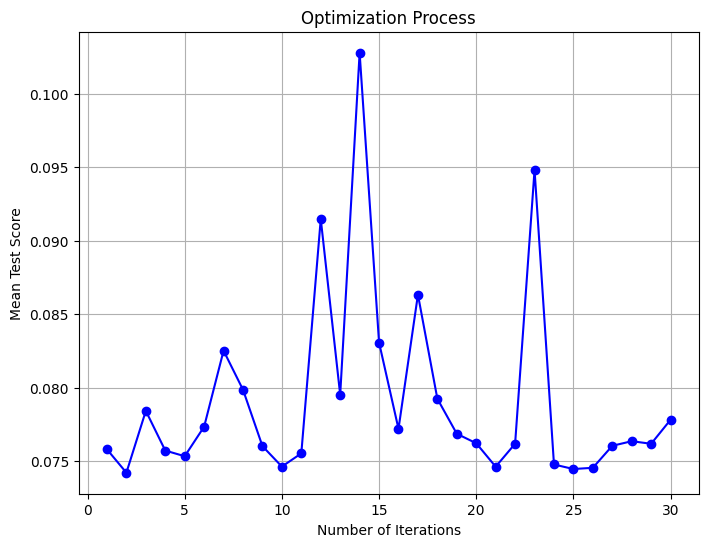

In [21]:
# Extract the results
results = pd.DataFrame(opt.cv_results_)
results['mean_test_score'] = -results['mean_test_score']

# Extract the mean test scores and number of iterations
iterations = np.arange(1, n_iter + 1)

# Plot the scores
plt.figure(figsize=(8, 6))
plt.plot(iterations, results['mean_test_score'], marker='o', linestyle='-', color='b')
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Test Score')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

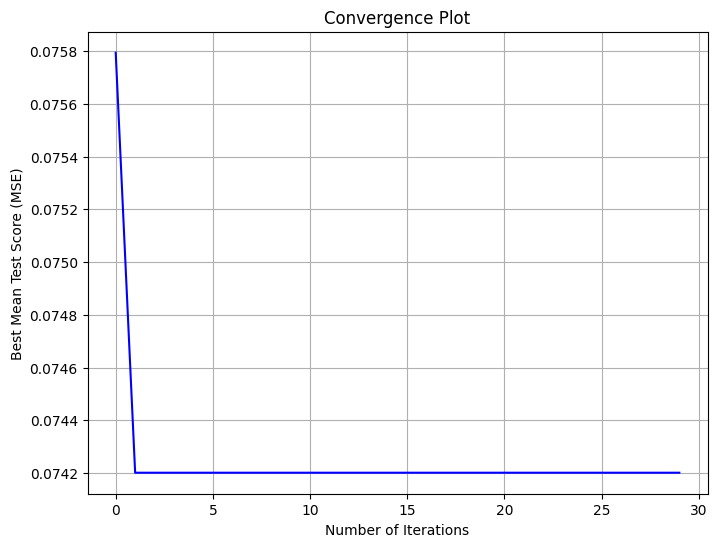

In [22]:
# Extract best scores at each iteration
best_scores = np.minimum.accumulate(results['mean_test_score'])

# Plot the convergence
plt.figure(figsize=(8, 6))
plt.plot(best_scores, linestyle='-', color='b')
plt.xlabel('Number of Iterations')
plt.ylabel('Best Mean Test Score (MSE)')
plt.title('Convergence Plot')
plt.grid(True)
plt.show()

0:	learn: 0.0058558	total: 1.62ms	remaining: 1.51s
50:	learn: 0.0000240	total: 74.8ms	remaining: 1.28s
100:	learn: 0.0000002	total: 146ms	remaining: 1.2s
150:	learn: 0.0000000	total: 220ms	remaining: 1.13s
200:	learn: 0.0000000	total: 290ms	remaining: 1.05s
250:	learn: 0.0000000	total: 360ms	remaining: 970ms
300:	learn: 0.0000000	total: 434ms	remaining: 904ms
350:	learn: 0.0000000	total: 503ms	remaining: 827ms
400:	learn: 0.0000000	total: 573ms	remaining: 753ms
450:	learn: 0.0000000	total: 643ms	remaining: 680ms
500:	learn: 0.0000000	total: 715ms	remaining: 609ms
550:	learn: 0.0000000	total: 789ms	remaining: 540ms
600:	learn: 0.0000000	total: 860ms	remaining: 468ms
650:	learn: 0.0000000	total: 933ms	remaining: 397ms
700:	learn: 0.0000000	total: 1s	remaining: 326ms
750:	learn: 0.0000000	total: 1.08s	remaining: 255ms
800:	learn: 0.0000000	total: 1.15s	remaining: 182ms
850:	learn: 0.0000000	total: 1.22s	remaining: 111ms
900:	learn: 0.0000000	total: 1.3s	remaining: 38.9ms
927:	learn: 0.000

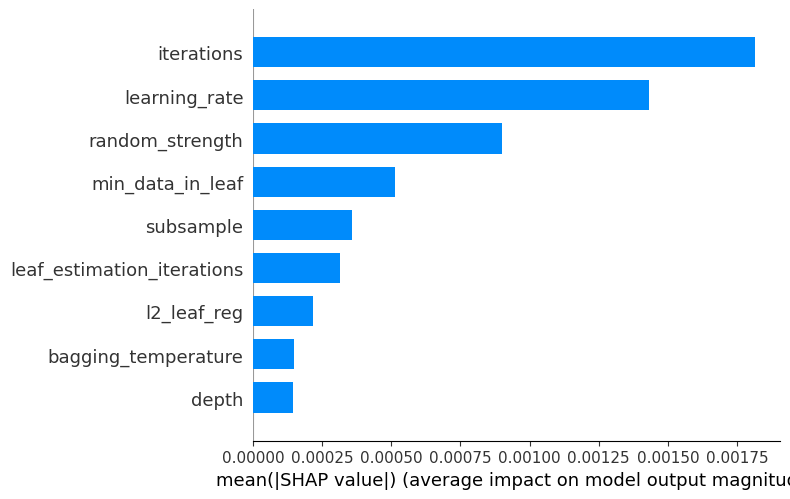

In [23]:
results = opt.cv_results_
params = results['params']
mean_test_scores = -results['mean_test_score']  # Mean test scores are negative due to the scoring used

# Create a DataFrame for analysis
hyperparams_df = pd.DataFrame(params)
hyperparams_df['mean_test_score'] = mean_test_scores

# Fit a simple model to explain the hyperparameter importance
hyperparam_model = copy.deepcopy(opt.best_estimator_)
hyperparam_model.fit(hyperparams_df.drop('mean_test_score', axis=1), hyperparams_df['mean_test_score'])

# Create a SHAP explainer
explainer = shap.Explainer(hyperparam_model)
shap_values = explainer(hyperparams_df.drop('mean_test_score', axis=1))

# Plot feature importance based on SHAP values
shap.summary_plot(shap_values, hyperparams_df.drop('mean_test_score', axis=1), plot_type="bar")

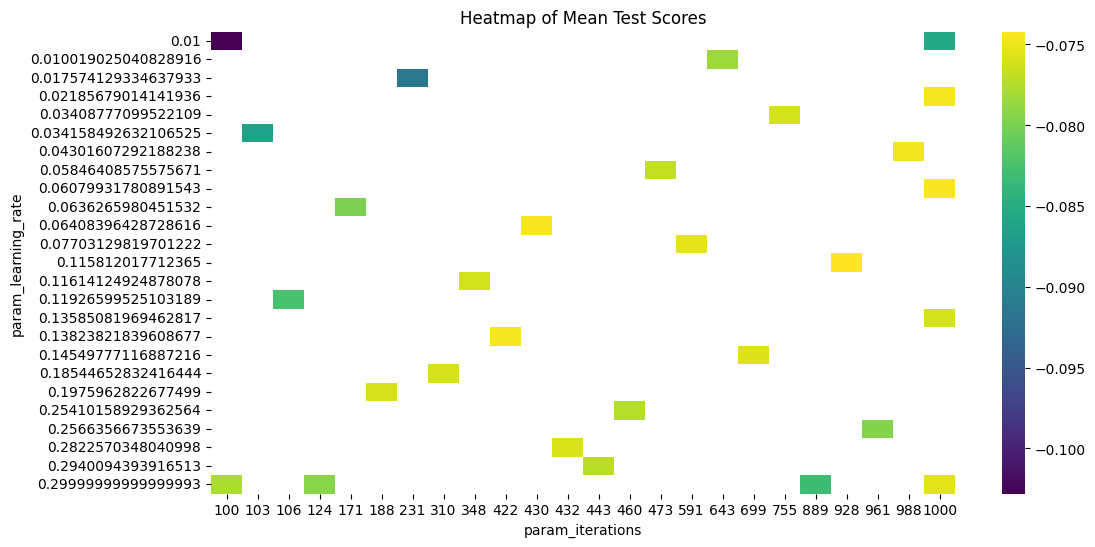

In [24]:
# Create a pivot table for the heatmap
pivot_table = pd.DataFrame(results).pivot_table(
    values='mean_test_score',
    index='param_learning_rate',
    columns='param_iterations',
    aggfunc='mean'
)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=False, fmt=".1f", cmap="viridis")
plt.title('Heatmap of Mean Test Scores')
plt.show()

In [25]:
best_model = opt.best_estimator_

In [26]:
preds = best_model.predict(X_test)
errors = np.abs(test_df[target] - preds)

# Create a DataFrame to store actual, predicted, and errors
error_df = test_df[['Ticker', 'Date', target]].copy()
error_df['Predicted'] = preds
error_df['Error'] = errors

# Sort by error in descending order and display the top 30
top_30_errors = error_df.sort_values(by='Error', ascending=False).head(30)
print(top_30_errors)

      Ticker        Date  Future_Price_pct_diff_1  Predicted     Error
22705   SMCI  2024-06-30                 2.553191   1.133232  1.419959
10674   FSLR  2024-09-30                 0.335664  -0.006151  0.341815
4599     CCL  2024-02-29                -0.048040   0.276849  0.324890
17617   MRNA  2024-09-30                 0.114396  -0.180579  0.294974
17970   MTCH  2024-03-31                -0.068283   0.195358  0.263642
19499     ON  2024-03-31                -0.101345   0.154500  0.255845
1237    ALGN  2024-03-31                -0.102581   0.133583  0.236164
11317   GNRC  2024-03-31                 0.186123   0.419670  0.233547
19007   NVDA  2024-01-31                -0.127237   0.088630  0.215866
18370    NEM  2024-06-30                -0.127259   0.083844  0.211103
22704   SMCI  2024-03-31                 0.036613   0.246383  0.209770
19009   NVDA  2024-07-31                 0.404360   0.208314  0.196046
12384    HPE  2024-10-31                 0.178248  -0.017542  0.195790
6274  

<Axes: >

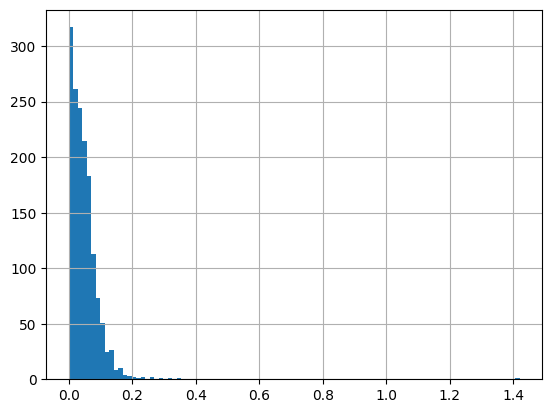

In [27]:
error_df['Error'].hist(bins=100)

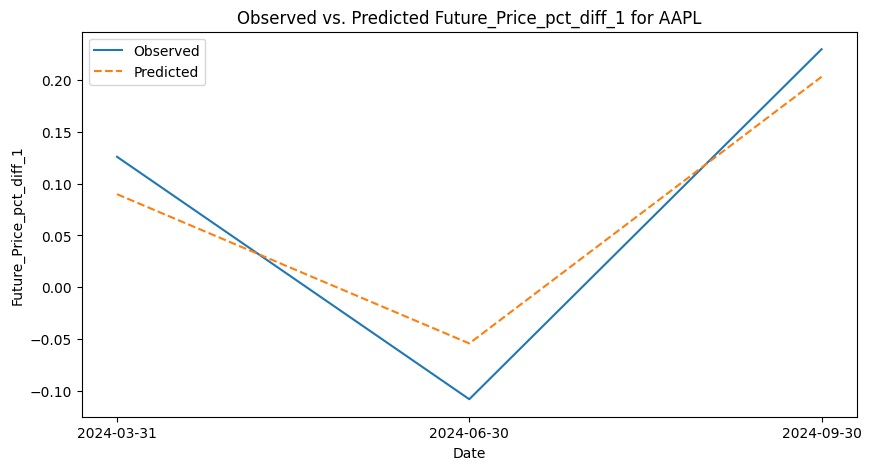

Mean error: 0.03888292327338427


In [28]:
ticker = 'AAPL'

ticker_example = test_df[test_df['Ticker'] == ticker]
plt.figure(figsize=(10, 5))
plt.plot(ticker_example['Date'], ticker_example[target], label='Observed')
plt.plot(ticker_example['Date'], best_model.predict(Pool(ticker_example[features], cat_features=cat_features)),
         label='Predicted', linestyle='--')
plt.title(f'Observed vs. Predicted {target} for {ticker}')
plt.xlabel('Date')
plt.ylabel(target)
plt.legend()
plt.show()

print(f'Mean error: {error_df.loc[error_df["Ticker"]==ticker, "Error"].mean()}')